In [3]:
tf.__version__

'2.5.0'

In [4]:
import numpy as np
import pandas as pd
import tensorflow as tf
import os
import keras
import matplotlib.pyplot as plt
from keras.callbacks import EarlyStopping, ModelCheckpoint

ModuleNotFoundError: No module named 'matplotlib'

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
    try:
        for gpu in gpus:
            tf.config.experimental.set_memory_growth(gpu, True)
        logical_gpus = tf.config.experimental.list_logical_devices('GPU')
        print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
    except RuntimeError as e:
        print(e)

In [ ]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


False

In [4]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"

## 1. 데이터 전처리

In [5]:
#당진, 울산 기상 관측 데이터
#공유파일을 엑셀상에서 GHI 단위 바꿈! 
raw_weather_dangjin = pd.read_csv('proc_by_yj15-21/dangjin_obs_15_21.csv')
raw_weather_ulsan = pd.read_csv('proc_by_yj/ulsan_obs_15_21.csv')
# floating, warehouse, dangjin, ulsan 발전량 데이터
raw_power_dataset = pd.read_csv('proc_by_yj/energy_new.csv') 

#### 1.1 기상데이터

In [6]:
print(raw_weather_dangjin.shape, raw_weather_ulsan.shape)
raw_weather_dangjin.head()

(55488, 8) (55488, 8)


,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-1.812707,4.980371,3.0
1,2015-01-01 1:00,NaN,0.0,-4.4,47.0,-1.846909,5.074340,3.0
2,2015-01-01 2:00,NaN,0.0,-4.6,50.0,-1.675899,4.604494,3.0
3,2015-01-01 3:00,NaN,0.0,-4.7,50.0,-3.985283,4.749476,3.0
4,2015-01-01 4:00,NaN,0.0,-5.0,56.0,-3.213938,3.830222,3.0


In [7]:
cos_time = []
for i in range(raw_weather_dangjin['Time'].shape[0]):
     cos_time.append(np.cos(2*np.pi/24*int(raw_weather_dangjin['Time'][i][-5:-3])))
cos_weather_dangjin = pd.concat([raw_weather_dangjin,pd.DataFrame(cos_time)],axis=1)
cos_weather_ulsan = pd.concat([raw_weather_ulsan,pd.DataFrame(cos_time)],axis=1)
cos_weather_dangjin.rename(columns = {0:'cos(time)'}, inplace=True)
cos_weather_ulsan.rename(columns = {0:'cos(time)'}, inplace=True)

In [8]:
cos_weather_dangjin.head()

,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,cos(time)
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-1.812707,4.980371,3.0,1.000000
1,2015-01-01 1:00,NaN,0.0,-4.4,47.0,-1.846909,5.074340,3.0,0.965926
2,2015-01-01 2:00,NaN,0.0,-4.6,50.0,-1.675899,4.604494,3.0,0.866025
3,2015-01-01 3:00,NaN,0.0,-4.7,50.0,-3.985283,4.749476,3.0,0.707107
4,2015-01-01 4:00,NaN,0.0,-5.0,56.0,-3.213938,3.830222,3.0,0.500000


In [9]:
cos_weather_ulsan.head()

,Time,ghi,GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,cos(time)
0,2015-01-01 0:00,NaN,0.0,NaN,NaN,-6.108002,2.223131e+00,1,1.000000
1,2015-01-01 1:00,NaN,0.0,-1.0,42.0,-4.500000,-1.100000e-15,1,0.965926
2,2015-01-01 2:00,NaN,0.0,-1.3,39.0,-2.185478,2.604551e+00,1,0.866025
3,2015-01-01 3:00,NaN,0.0,-2.5,49.0,-3.213938,3.830222e+00,1,0.707107
4,2015-01-01 4:00,NaN,0.0,-3.3,36.0,-5.826094,2.120525e+00,1,0.500000


In [10]:
weather_dangjin = cos_weather_dangjin[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]
weather_ulsan = cos_weather_ulsan[[
                             'cos(time)',
                             'GHI',
                             'Temperature',
                             'Humidity',
                             'Wind_x',
                             'Wind_y']]

#### 1.2 발전량 데이터

In [11]:
power_dataset = raw_power_dataset[:]
power_dataset

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan_not_used,ulsan
0,2015-01-01 1:00,0.0,0.0,0.0,NaN,NaN
1,2015-01-01 2:00,0.0,0.0,0.0,NaN,NaN
2,2015-01-01 3:00,0.0,0.0,0.0,NaN,NaN
3,2015-01-01 4:00,0.0,0.0,0.0,NaN,NaN
4,2015-01-01 5:00,0.0,0.0,0.0,NaN,NaN
...,...,...,...,...,...,...
53347,2021-01-31 20:00,0.0,0.0,0.0,0.0,0.0
53348,2021-01-31 21:00,0.0,0.0,0.0,0.0,0.0
53349,2021-01-31 22:00,0.0,0.0,0.0,0.0,0.0
53350,2021-01-31 23:00,0.0,0.0,0.0,0.0,0.0


In [12]:
print(weather_dangjin.shape) 
print(power_dataset.shape) 

(55488, 6)
(53352, 6)


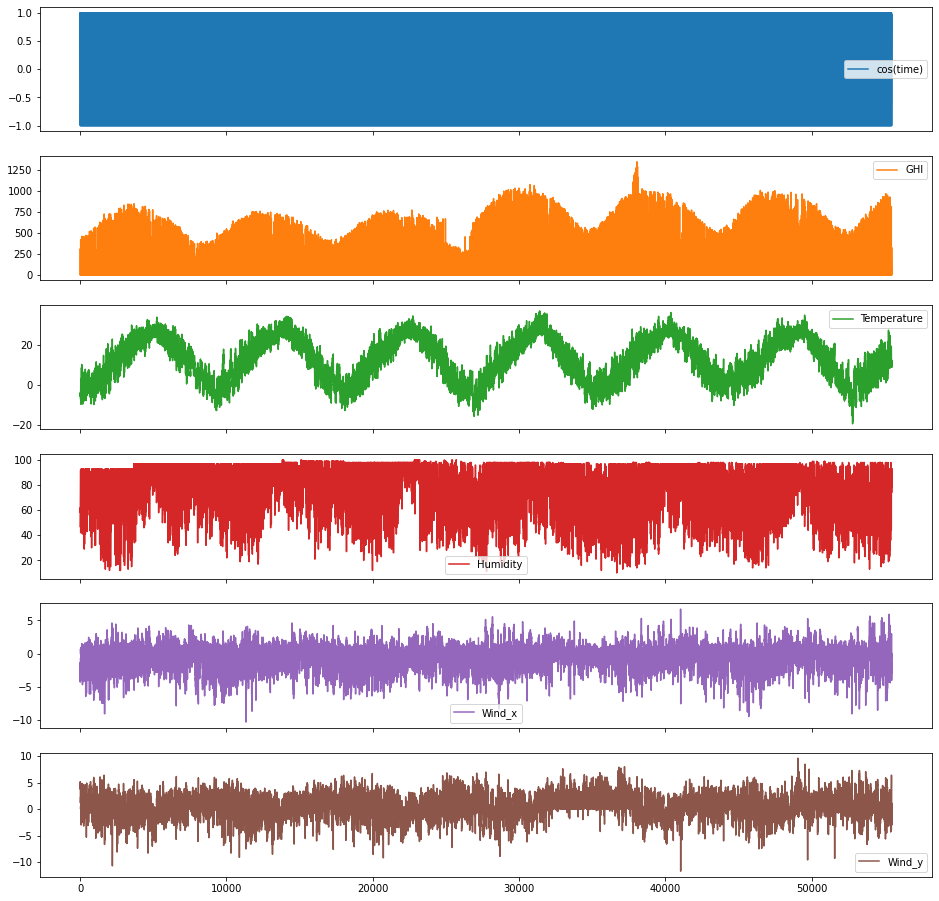

In [13]:
weather_dangjin.plot(subplots=True, figsize=(16, 16));

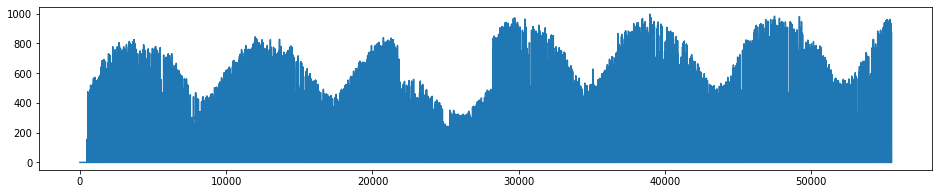

In [14]:
weather_ulsan['GHI'].plot(figsize=(16,3));

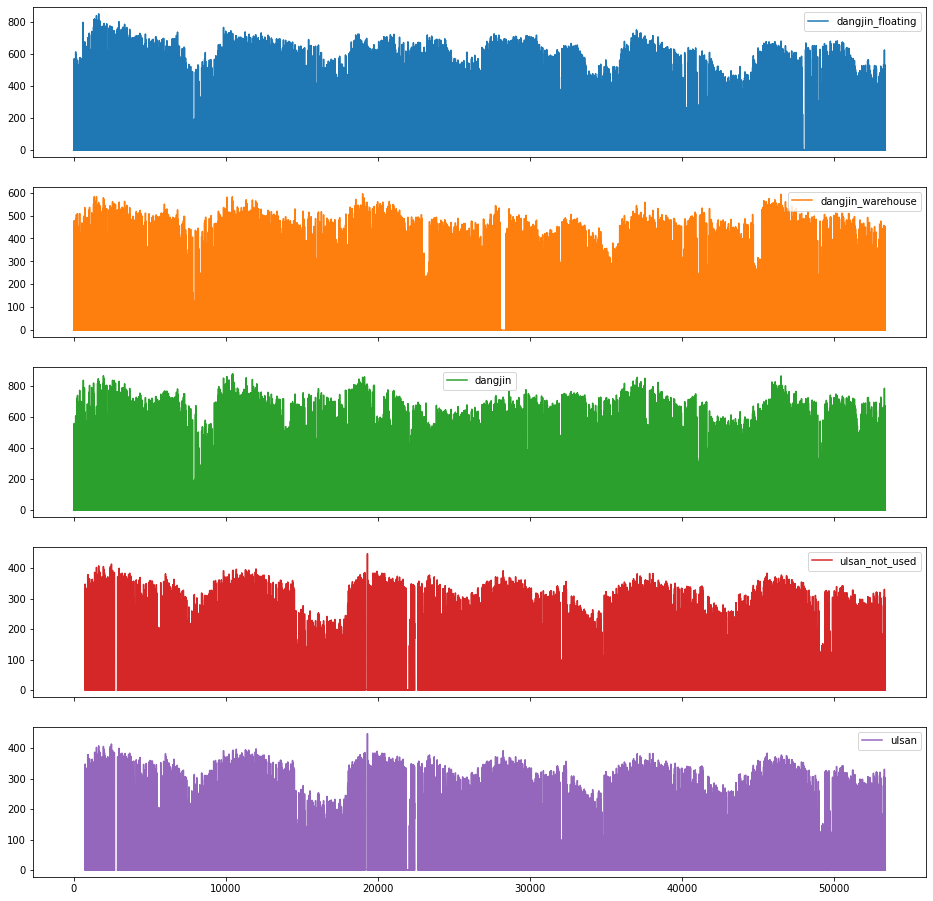

In [15]:
power_dataset.plot(subplots=True, figsize=(16,16));

In [18]:
# 이상치 NaN 값으로 변경
for i in range(len(weather_dangjin)):
    if weather_dangjin['GHI'][i] > 1000:
        weather_dangjin['GHI'][i] = np.nan;
'''
for i in range(len(raw_data_dangjin)):
    if raw_data_dangjin['Visibility'][i] > 5100:
        raw_data_dangjin['Visibility'][i] = np.nan
''';


In [19]:
weather_dangjin['GHI'][np.where(raw_weather_dangjin['Time']=='2018-01-01 0:00')[0][0]:]

26304     0.000000
26305     0.000000
26306     0.000000
26307     0.000000
26308     0.000000
           ...    
55483    30.555558
55484     0.000000
55485     0.000000
55486     0.000000
55487     0.000000
Name: GHI, Length: 29184, dtype: float64

In [20]:
power_dataset = power_dataset.drop(['ulsan_not_used','time'], axis=1)

In [21]:
# NaN 값들을 K-Nearest Neighbor로 값을 채워줌
from sklearn.impute import KNNImputer
from numpy import isnan

imputer = KNNImputer()
imputer.fit(weather_dangjin.values)
imp_weather_dangjin = imputer.transform(weather_dangjin.values)

imputer.fit(weather_ulsan.values)
imp_weather_ulsan = imputer.transform(weather_ulsan.values)

imputer.fit(power_dataset.values)
proc_power_dataset = imputer.transform(power_dataset.values)

print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_dangjin).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(imp_weather_ulsan).flatten()))
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(proc_power_dataset).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0
데이터 내에 존재하는 NaN의 갯수: 0


In [22]:
bound_for_scaler = np.where(raw_weather_dangjin['Time']=='2018-01-01 0:00')[0][0]

In [23]:
imp_weather_dangjin_1 = imp_weather_dangjin[bound_for_scaler:]
imp_weather_dangjin_2 = imp_weather_dangjin[:bound_for_scaler]

In [24]:
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
import scipy as sp
import scipy.stats
scaler = MinMaxScaler()
scaler.fit(imp_weather_dangjin_1)
imp_weather_dangjin_1_scaled = scaler.transform(imp_weather_dangjin_1)

scaler.fit(imp_weather_dangjin_2)
imp_weather_dangjin_2_scaled = scaler.transform(imp_weather_dangjin_2)

scaler.fit(imp_weather_ulsan)
imp_weather_ulsan_scaled = scaler.transform(imp_weather_ulsan)

imp_weather_dangjin_scaled = pd.concat([pd.DataFrame(imp_weather_dangjin_2_scaled),
                                        pd.DataFrame(imp_weather_dangjin_1_scaled)], axis =0)

proc_weather_dangjin = pd.DataFrame(data = np.array(imp_weather_dangjin_scaled),
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])
proc_weather_ulsan = pd.DataFrame(data=imp_weather_ulsan_scaled, 
                                 columns=['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y'])


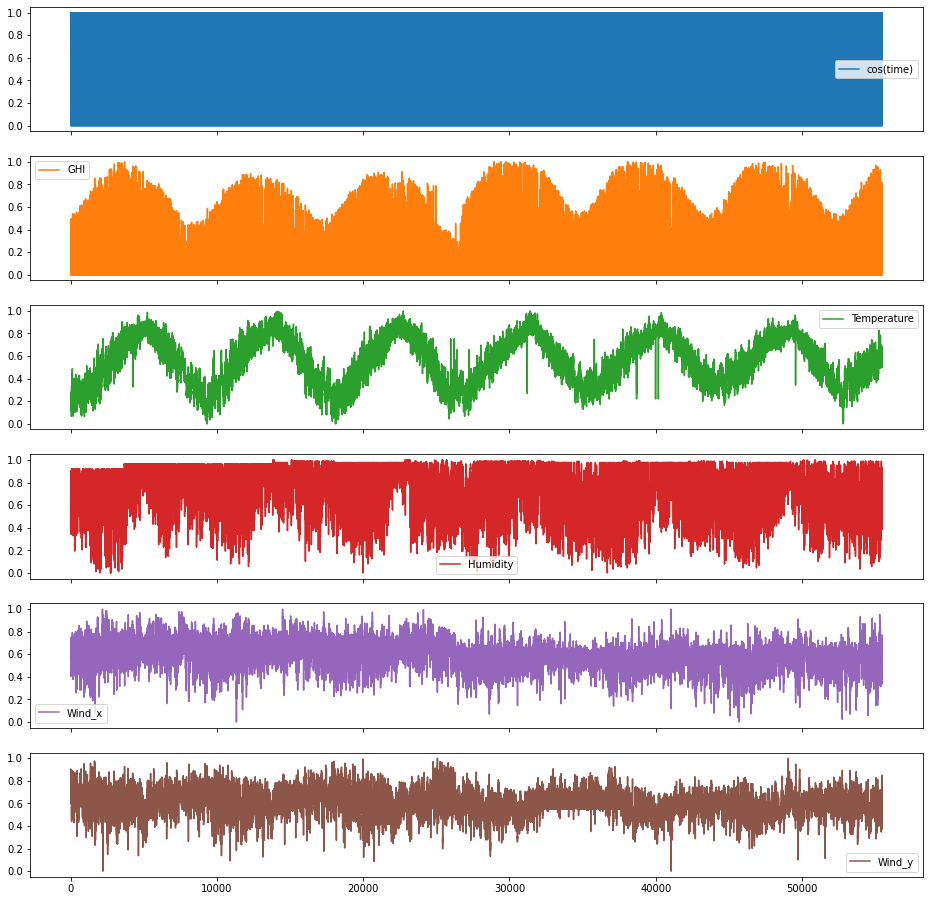

In [25]:
proc_weather_dangjin.plot(subplots=True, figsize=(16,16));

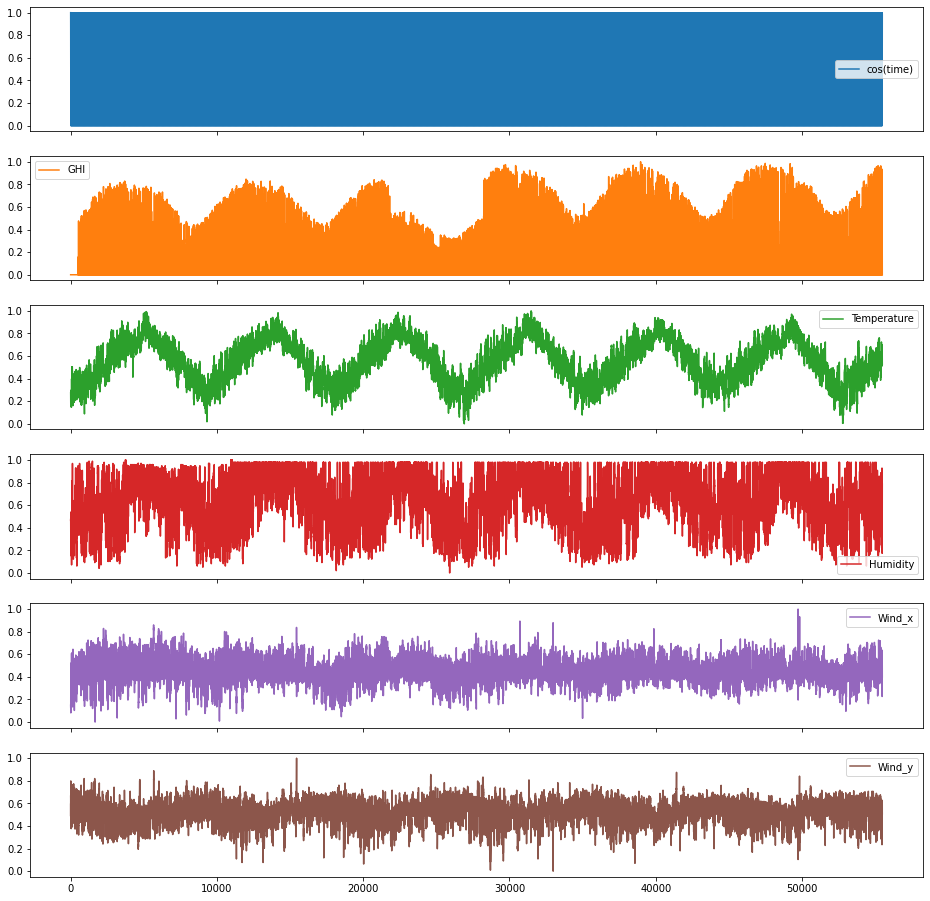

In [26]:
proc_weather_ulsan.plot(subplots=True, figsize=(16,16));

In [27]:
proc_power_dataset = pd.DataFrame(power_dataset)

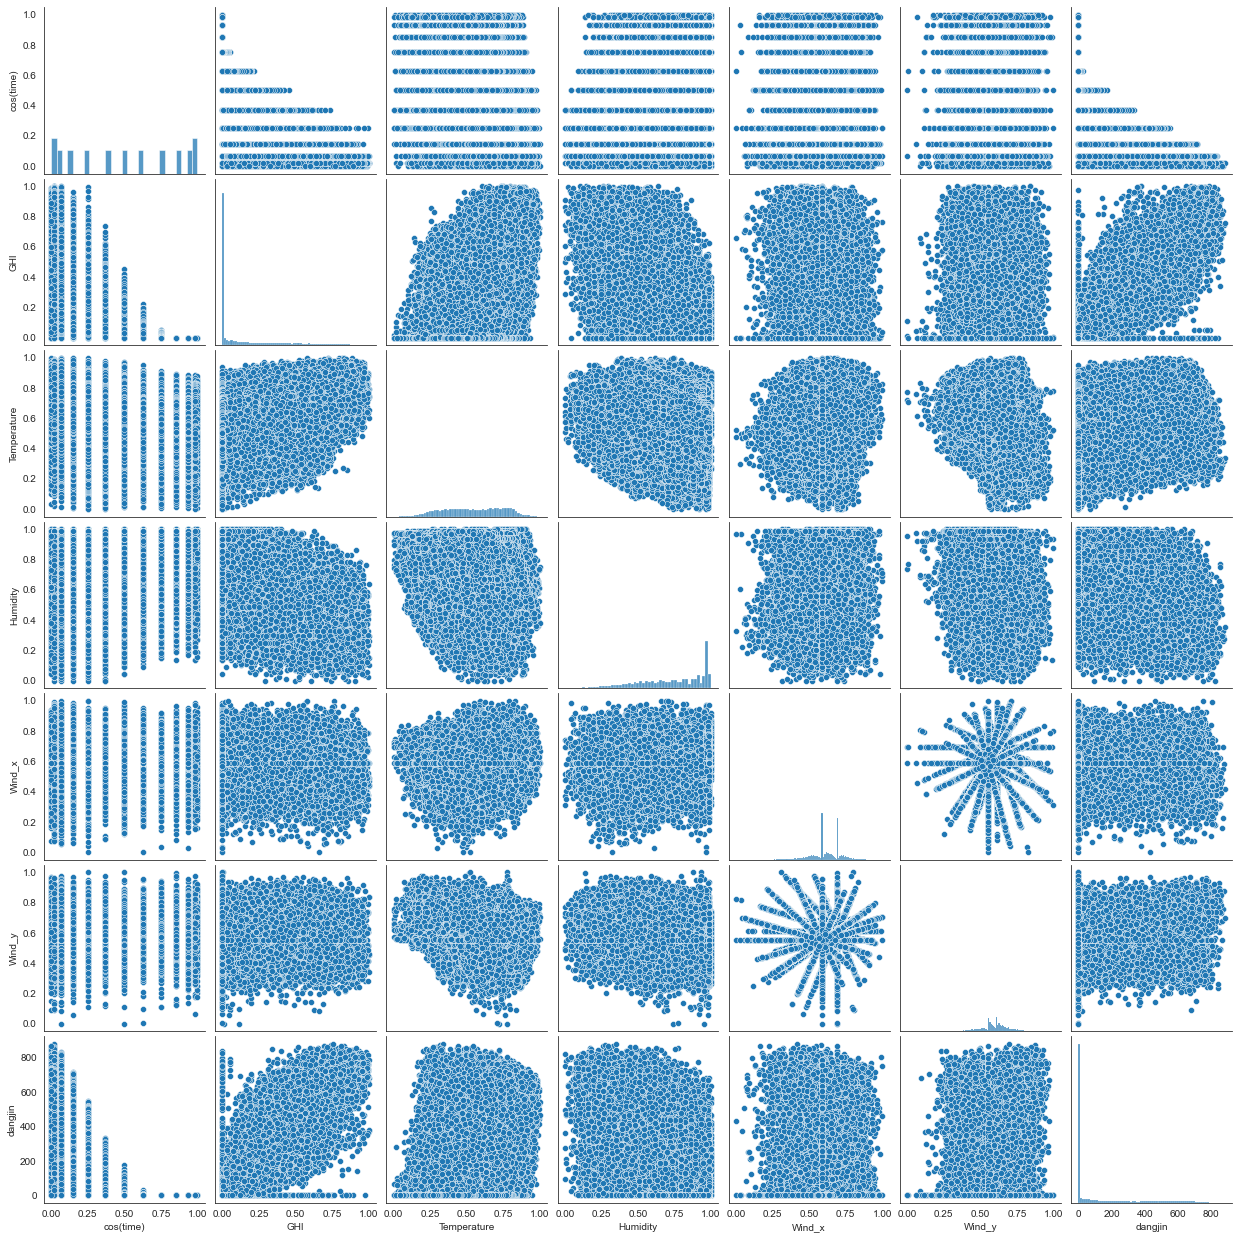

In [28]:
import seaborn as sns
sns.set_style("white")
sns.pairplot(pd.concat([proc_weather_dangjin[['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y']], proc_power_dataset['dangjin']],
                                          axis=1))


## 2. 모델링 및 학습

In [29]:
proc_power_dataset.rename(columns = {0:'dangjin_floating',
                                     1:'dangjin_warehouse',
                                     2:'dangjin',
                                     3:'ulsan'}, inplace = True)

In [80]:
temp_dataset_dangjin

,cos(time),GHI,Temperature,Humidity,Wind_x,Wind_y,Cloud,dangjin_floating,dangjin_warehouse,dangjin
0,1.000000,0.000000,0.276596,0.631818,0.570500,0.895111,3.0,0.0,0.0,0.0
1,0.982963,0.000000,0.176596,0.397727,0.568211,0.900475,3.0,0.0,0.0,0.0
2,0.933013,0.000000,0.172340,0.431818,0.579657,0.873654,3.0,0.0,0.0,0.0
3,0.853553,0.000000,0.170213,0.431818,0.425091,0.881930,3.0,0.0,0.0,0.0
4,0.750000,0.000000,0.163830,0.500000,0.476717,0.829455,3.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
55483,0.629410,0.030641,0.524064,0.831461,0.444444,0.549686,4.0,NaN,NaN,NaN
55484,0.750000,0.000000,0.516934,0.808989,0.511012,0.570576,4.0,NaN,NaN,NaN
55485,0.853553,0.000000,0.509804,0.853933,0.567419,0.509953,4.0,NaN,NaN,NaN
55486,0.933013,0.000000,0.506239,0.898876,0.586420,0.554385,4.0,NaN,NaN,NaN


In [83]:
temp_dataset_dangjin = pd.concat([proc_weather_dangjin,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset.drop('ulsan', axis=1)],axis=1)
temp_dataset_ulsan = pd.concat([proc_weather_ulsan,
                             raw_weather_dangjin['Cloud'],
                             proc_power_dataset['ulsan']],axis=1)

imputer.fit(temp_dataset_dangjin.values)
final_dataset_dangjin = imputer.transform(temp_dataset_dangjin.values)

imputer.fit(temp_dataset_ulsan.values)
final_dataset_ulsan = imputer.transform(temp_dataset_ulsan.values)

In [86]:
final_dataset_dangjin = pd.DataFrame(final_dataset_dangjin, columns = temp_dataset_dangjin.columns)
final_dataset_ulsan = pd.DataFrame(final_dataset_ulsan, columns = temp_dataset_ulsan.columns)

In [88]:
print("데이터 내에 존재하는 NaN의 갯수:", sum(isnan(np.array(final_dataset_ulsan)).flatten()))

데이터 내에 존재하는 NaN의 갯수: 0


In [53]:
from sklearn.model_selection import train_test_split

In [89]:
def sola_nmae(answer_df, submission_df):
    submission = submission_df[submission_df['time'].isin(answer_df['time'])]
    submission.index = range(submission.shape[0])
    
    # 시간대별 총 발전량
    sum_submission = submission.iloc[:,1:].sum(axis=1)
    sum_answer = answer_df.iloc[:,1:].sum(axis=1)
    
    # 발전소 발전용량
    capacity = {
        'dangjin_floating':1000, # 당진수상태양광 발전용량
        'dangjin_warehouse':700, # 당진자재창고태양광 발전용량
        'dangjin':1000, # 당진태양광 발전용량
        'ulsan':500 # 울산태양광 발전용량
    }
    # 총 발전용량
    total_capacity = np.sum(list(capacity.values()))
    # 총 발전용량 절대오차
    absolute_error = (sum_answer - sum_submission).abs()
    # 발전용량으로 정규화
    absolute_error /= total_capacity
    # 총 발전용량의 10% 이상 발전한 데이터 인덱스 추출
    target_idx = sum_answer[sum_answer>=total_capacity*0.1].index
    # NMAE(%)
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

In [97]:
def plot_history(history):
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure(figsize=(20,20))

    plt.subplot(2,2,1)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MAE]')
    plt.plot(hist['epoch'], hist['mae'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mae'],label = 'Val Error')
    plt.ylim([0,150])
    plt.legend()

    plt.subplot(2,2,2)
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [MSE]')
    plt.plot(hist['epoch'], hist['mse'],label='Train Error')
    plt.plot(hist['epoch'], hist['val_mse'],label = 'Val Error')
    plt.ylim([0,80])
    plt.legend()
    plt.show()

In [96]:
from keras import layers
def build_model(x_train):
    model = keras.Sequential([
                            layers.Dense(256, activation='relu', input_shape=[len(x_train.keys())]),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(128, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(64, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(32, activation='relu'),
                            layers.Dropout(0.2),
                            layers.Dense(1)
                            ])

    optimizer = tf.keras.optimizers.Adam(0.001)

    model.compile(loss='mae',
                optimizer=optimizer,
                metrics=['mae','mse'])
    return model

In [50]:
def train_each_cloud(final_dataset_dangjin, final_dataset_ulsan, region):
    dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
    dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
    dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]
    
    ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
    ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
    ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]
    
    power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
    power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
    power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    if region == 'dangjin':
        train_dataset = final_dataset_dangjin[dangjin_start:dangjin_bound]
        test_dataset = final_dataset_dangjin[dangjin_bound:dangjin_end]
        for cloud_idx in [1,2,3,4]:
            cloud = train_dataset['Cloud'][train_dataset['Cloud']==cloud_idx].index
            cloud_train_dataset = pd.DataFrame()
            for i in cloud:
                cloud_train_dataset = pd.concat([cloud_train_dataset,train_dataset[i:i+1]], axis = 0)                              
                print(pd.DataFrame(cloud_train_dataset))
                for place in ['dangjin', 'dangjin_warehouse', 'dangjin_floating']:
                    x_train, x_test, y_train, y_test = train_test_split(cloud_train_dataset[['cos(time)',
                                                                                             'GHI',
                                                                                             'Temperature',
                                                                                             'Humidity',
                                                                                             'Wind_x',
                                                                                             'Wind_y']], 
                                                                        cloud_train_dataset[place],
                                                                        test_size=0.2, shuffle=False)
                    EPOCHS = 200
                    model = build_model(x_train)
                    history = model.fit(x_train, y_train, epochs=EPOCHS,
                                        batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])
                    plot_history(history)
                    loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
                    print("%s test set의 MAE: %.3f"%(place,mae1))

                    answer_df = test_dataset[place][np.where(test_dataset)]
                    test_period = test_dataset[['cos(time)',
                                                 'GHI',
                                                 'Temperature',
                                                 'Humidity',
                                                 'Wind_x',
                                                 'Wind_y']]
                    submission_df = np.squeeze(model_dangjin.predict(test_period))
                    
                    print("NMAE for MLP :",sola_nmae(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

        

In [123]:
dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]

ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]

power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]

In [154]:
for name in ['a','b','c']:
    globals()['model_{}'.format(name)] = 2*3

In [161]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 700
    target_idx = pd.DataFrame(sum_answer[sum_answer>=700*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [209]:
def train(final_dataset_dangjin, final_dataset_ulsan, region):
    model_list = []
    dangjin_start = np.where(raw_weather_dangjin['Time'] == '2015-02-01 0:00')[0][0]
    dangjin_bound = np.where(raw_weather_dangjin['Time'] == '2020-01-01 0:00')[0][0]
    dangjin_end = np.where(raw_weather_dangjin['Time'] == '2021-01-01 0:00')[0][0]
    
    ulsan_start = np.where(raw_weather_ulsan['Time'] == '2015-02-01 0:00')[0][0]
    ulsan_bound = np.where(raw_weather_ulsan['Time'] == '2020-01-01 0:00')[0][0]
    ulsan_end = np.where(raw_weather_ulsan['Time'] == '2021-01-01 0:00')[0][0]
    
    power_start = np.where(raw_power_dataset['time'] == '2015-02-01 0:00')[0][0]
    power_bound = np.where(raw_power_dataset['time'] == '2020-01-01 0:00')[0][0]
    power_end = np.where(raw_power_dataset['time'] == '2021-01-01 0:00')[0][0]
    
    es = EarlyStopping(monitor='val_loss', mode = 'min', verbose = 1, patience=30)
    mc = ModelCheckpoint('best_model.h5', monitor='val_loss', mode='min', save_best_only=True)
    
    if region == 'dangjin':
        train_dataset = final_dataset_dangjin[dangjin_start:dangjin_bound]
        test_dataset = final_dataset_dangjin[dangjin_bound:dangjin_end]
        '''
        for cloud_idx in [1,2,3,4]:
            cloud = train_dataset['Cloud'][train_dataset['Cloud']==cloud_idx].index
            cloud_train_dataset = pd.DataFrame()
            for i in cloud:
                cloud_train_dataset = pd.concat([cloud_train_dataset,train_dataset[i:i+1]], axis = 0)                              
                print(pd.DataFrame(cloud_train_dataset))
                '''
        for place in ['dangjin', 'dangjin_warehouse', 'dangjin_floating']:
            x_train, x_test, y_train, y_test = train_test_split(train_dataset[['cos(time)',
                                                                                     'GHI',
                                                                                     'Temperature',
                                                                                     'Humidity',
                                                                                     'Wind_x',
                                                                                     'Wind_y']], 
                                                                train_dataset[place],
                                                                test_size=0.2, shuffle=False)
            EPOCHS = 200
            model = build_model(x_train)
            history = model.fit(x_train, y_train, epochs=EPOCHS,
                                batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])
            
            plot_history(history)
            loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
            print("%s test set의 MAE: %.3f"%(place,mae1))
            globals()['model_{}'.format(place)] = model
            globals()['history_{}'.format(place)] = history
    
        return model_dangjin, model_dangjin_warehouse, model_dangjin_floating, history_dangjin, history_dangjin_warehouse, history_dangjin_floating
    
    if region =='ulsan':
        train_dataset = final_dataset_ulsan[ulsan_start:ulsan_bound]
        test_dataset = final_dataset_ulsan[ulsan_bound:ulsan_end]
        '''
        for cloud_idx in [1,2,3,4]:
        cloud = train_dataset['Cloud'][train_dataset['Cloud']==cloud_idx].index
        cloud_train_dataset = pd.DataFrame()
        for i in cloud:
        cloud_train_dataset = pd.concat([cloud_train_dataset,train_dataset[i:i+1]], axis = 0)                              
        print(pd.DataFrame(cloud_train_dataset))
        '''
        for place in ['ulsan']:
            x_train, x_test, y_train, y_test = train_test_split(train_dataset[['cos(time)',
                                                                         'GHI',
                                                                         'Temperature',
                                                                         'Humidity',
                                                                         'Wind_x',
                                                                         'Wind_y']], 
                                                    train_dataset[place],
                                                    test_size=0.2, shuffle=False)
            EPOCHS = 200
            model = build_model(x_train)
            history = model.fit(x_train, y_train, epochs=EPOCHS,
                    batch_size = 128, validation_split = 0.2, verbose=2,callbacks=[es,mc])

            plot_history(history)
            loss1, mae1, mse1 = model.evaluate(x_test, y_test, verbose=1)
            print("%s test set의 MAE: %.3f"%(place,mae1))

        return model, history
        
    '''
            answer_df = test_dataset[place]
            test_period = test_dataset[['cos(time)',
                                         'GHI',
                                         'Temperature',
                                         'Humidity',
                                         'Wind_x',
                                         'Wind_y']]
            submission_df = np.squeeze(model.predict(test_period))
            model_list.append(model)
            print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))'''
            
            

Epoch 1/200
216/216 - 1s - loss: 33.7746 - mae: 33.7746 - mse: 4843.9873 - val_loss: 19.9483 - val_mae: 19.9483 - val_mse: 1552.2892
Epoch 2/200
216/216 - 0s - loss: 24.9651 - mae: 24.9651 - mse: 2373.8420 - val_loss: 29.6338 - val_mae: 29.6338 - val_mse: 3229.5918
Epoch 3/200
216/216 - 0s - loss: 24.4973 - mae: 24.4973 - mse: 2293.9553 - val_loss: 21.4191 - val_mae: 21.4191 - val_mse: 1834.1406
Epoch 4/200
216/216 - 1s - loss: 23.6650 - mae: 23.6650 - mse: 2157.5959 - val_loss: 18.9064 - val_mae: 18.9064 - val_mse: 1425.7997
Epoch 5/200
216/216 - 0s - loss: 23.5693 - mae: 23.5693 - mse: 2145.4170 - val_loss: 19.6704 - val_mae: 19.6704 - val_mse: 1589.1504
Epoch 6/200
216/216 - 1s - loss: 23.1216 - mae: 23.1216 - mse: 2079.3572 - val_loss: 18.8014 - val_mae: 18.8014 - val_mse: 1481.9174
Epoch 7/200
216/216 - 0s - loss: 22.7212 - mae: 22.7212 - mse: 2012.8436 - val_loss: 23.9059 - val_mae: 23.9059 - val_mse: 2223.9080
Epoch 8/200
216/216 - 1s - loss: 22.6889 - mae: 22.6889 - mse: 2005.1

Epoch 63/200
216/216 - 0s - loss: 20.5106 - mae: 20.5106 - mse: 1675.6119 - val_loss: 24.6405 - val_mae: 24.6405 - val_mse: 2346.5496
Epoch 64/200
216/216 - 0s - loss: 20.6637 - mae: 20.6637 - mse: 1703.5884 - val_loss: 20.4402 - val_mae: 20.4402 - val_mse: 1757.6296
Epoch 65/200
216/216 - 0s - loss: 20.5373 - mae: 20.5373 - mse: 1675.3053 - val_loss: 21.2098 - val_mae: 21.2098 - val_mse: 1909.9021
Epoch 66/200
216/216 - 0s - loss: 20.5725 - mae: 20.5725 - mse: 1687.3116 - val_loss: 23.4258 - val_mae: 23.4258 - val_mse: 2147.2605
Epoch 67/200
216/216 - 0s - loss: 20.6436 - mae: 20.6436 - mse: 1684.2526 - val_loss: 21.4776 - val_mae: 21.4776 - val_mse: 1879.4781
Epoch 68/200
216/216 - 0s - loss: 20.7984 - mae: 20.7984 - mse: 1715.8933 - val_loss: 21.6329 - val_mae: 21.6329 - val_mse: 1994.4841
Epoch 69/200
216/216 - 0s - loss: 20.6142 - mae: 20.6142 - mse: 1682.2439 - val_loss: 19.8401 - val_mae: 19.8401 - val_mse: 1679.1948
Epoch 70/200
216/216 - 0s - loss: 20.4778 - mae: 20.4778 - mse

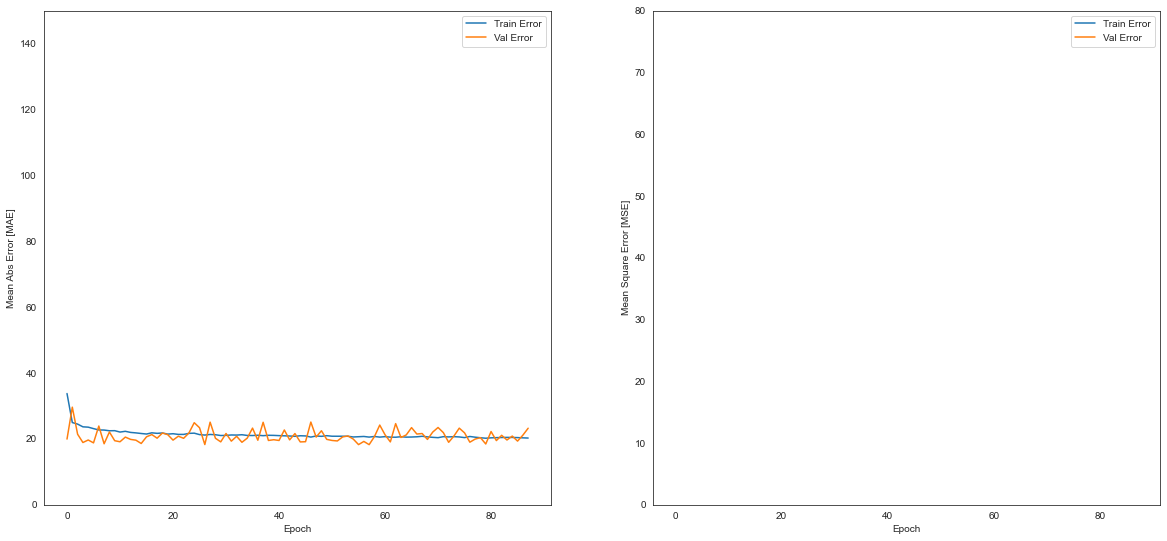

270/270 [==============================] - 0s 1ms/step - loss: 19.6742 - mae: 19.6742 - mse: 1568.8713
ulsan test set의 MAE: 19.674


In [210]:
model_ulsan, history_ulsan = train(final_dataset_dangjin, final_dataset_ulsan, 'ulsan')

Epoch 1/200
216/216 - 1s - loss: 69.7017 - mae: 69.7017 - mse: 21509.1465 - val_loss: 41.7942 - val_mae: 41.7942 - val_mse: 7210.6812
Epoch 2/200
216/216 - 1s - loss: 49.6718 - mae: 49.6718 - mse: 9784.8379 - val_loss: 41.0209 - val_mae: 41.0209 - val_mse: 6935.9434
Epoch 3/200
216/216 - 1s - loss: 48.3959 - mae: 48.3959 - mse: 9304.5645 - val_loss: 39.0674 - val_mae: 39.0674 - val_mse: 6661.6099
Epoch 4/200
216/216 - 1s - loss: 47.5527 - mae: 47.5527 - mse: 9089.9404 - val_loss: 38.9880 - val_mae: 38.9880 - val_mse: 6660.9404
Epoch 5/200
216/216 - 0s - loss: 45.8745 - mae: 45.8745 - mse: 8523.4766 - val_loss: 41.4395 - val_mae: 41.4395 - val_mse: 7944.1509
Epoch 6/200
216/216 - 1s - loss: 45.2744 - mae: 45.2744 - mse: 8271.1270 - val_loss: 37.8887 - val_mae: 37.8887 - val_mse: 6823.8540
Epoch 7/200
216/216 - 1s - loss: 45.2643 - mae: 45.2643 - mse: 8431.2734 - val_loss: 37.7226 - val_mae: 37.7226 - val_mse: 6703.4946
Epoch 8/200
216/216 - 0s - loss: 44.9973 - mae: 44.9973 - mse: 8199.

Epoch 63/200
216/216 - 0s - loss: 40.7347 - mae: 40.7347 - mse: 6920.1768 - val_loss: 38.8981 - val_mae: 38.8981 - val_mse: 7342.3267
Epoch 64/200
216/216 - 0s - loss: 40.8058 - mae: 40.8058 - mse: 7030.4194 - val_loss: 38.2108 - val_mae: 38.2108 - val_mse: 6620.0156
Epoch 65/200
216/216 - 0s - loss: 41.2137 - mae: 41.2137 - mse: 7103.1079 - val_loss: 37.9701 - val_mae: 37.9701 - val_mse: 6991.4639
Epoch 66/200
216/216 - 0s - loss: 40.8412 - mae: 40.8412 - mse: 7020.9888 - val_loss: 38.8271 - val_mae: 38.8271 - val_mse: 7186.9141
Epoch 67/200
216/216 - 0s - loss: 40.4548 - mae: 40.4548 - mse: 6909.2319 - val_loss: 38.9318 - val_mae: 38.9318 - val_mse: 7445.7417
Epoch 68/200
216/216 - 1s - loss: 40.8290 - mae: 40.8290 - mse: 7016.2383 - val_loss: 36.0984 - val_mae: 36.0984 - val_mse: 6789.0352
Epoch 69/200
216/216 - 0s - loss: 40.5559 - mae: 40.5559 - mse: 6968.9170 - val_loss: 37.6795 - val_mae: 37.6795 - val_mse: 6716.5137
Epoch 70/200
216/216 - 0s - loss: 40.6538 - mae: 40.6538 - mse

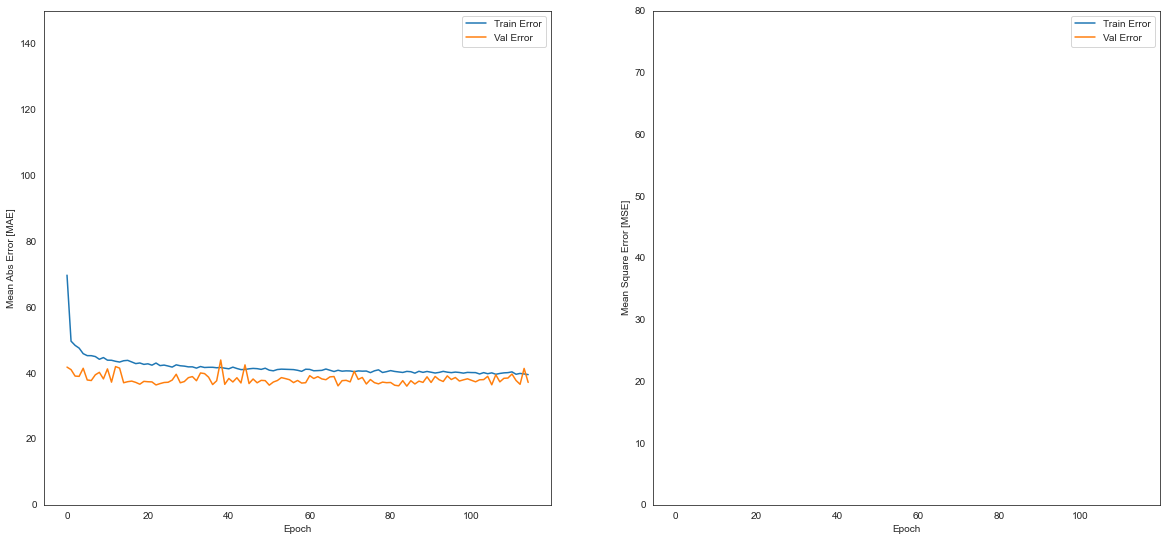

270/270 [==============================] - 0s 1ms/step - loss: 37.1741 - mae: 37.1741 - mse: 7351.6099
dangjin test set의 MAE: 37.174
Epoch 1/200
216/216 - 1s - loss: 45.3186 - mae: 45.3186 - mse: 9099.4629 - val_loss: 24.8901 - val_mae: 24.8901 - val_mse: 2799.2126
Epoch 2/200
216/216 - 1s - loss: 34.6735 - mae: 34.6735 - mse: 4880.9917 - val_loss: 23.6409 - val_mae: 23.6409 - val_mse: 2498.6133
Epoch 3/200
216/216 - 0s - loss: 33.3841 - mae: 33.3841 - mse: 4623.4536 - val_loss: 24.5697 - val_mae: 24.5697 - val_mse: 2759.1499
Epoch 4/200
216/216 - 1s - loss: 32.7757 - mae: 32.7757 - mse: 4498.0132 - val_loss: 23.3083 - val_mae: 23.3083 - val_mse: 2716.0386
Epoch 5/200
216/216 - 0s - loss: 32.5448 - mae: 32.5448 - mse: 4449.2065 - val_loss: 24.2833 - val_mae: 24.2833 - val_mse: 2916.0010
Epoch 6/200
216/216 - 0s - loss: 31.7412 - mae: 31.7412 - mse: 4318.2432 - val_loss: 25.8996 - val_mae: 25.8996 - val_mse: 3256.1904
Epoch 7/200
216/216 - 1s - loss: 31.5956 - mae: 31.5956 - mse: 4240.2

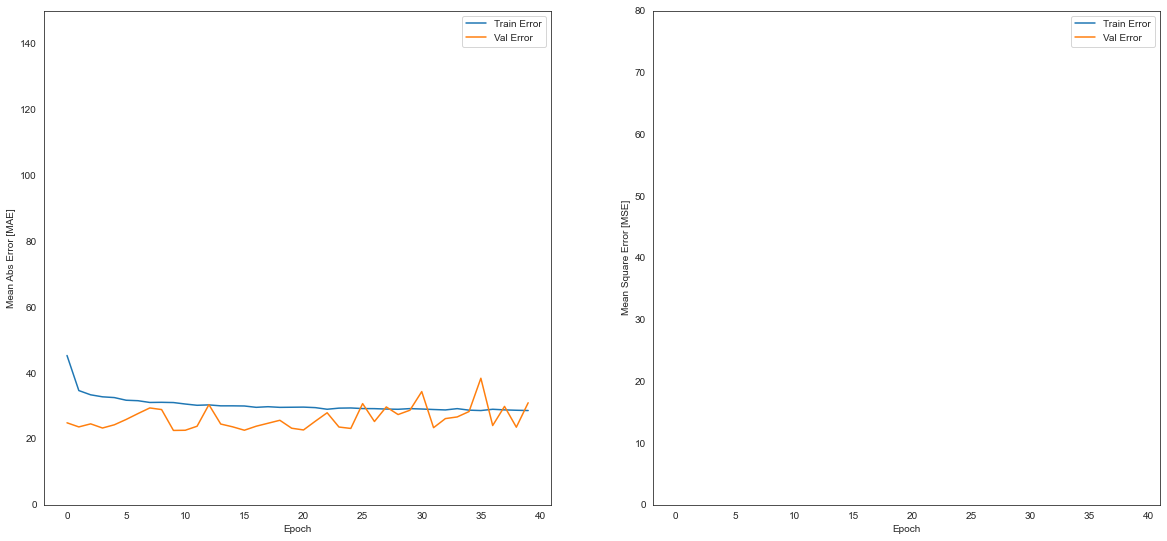

270/270 [==============================] - 0s 1ms/step - loss: 29.1878 - mae: 29.1878 - mse: 4205.0059
dangjin_warehouse test set의 MAE: 29.188
Epoch 1/200
216/216 - 1s - loss: 63.3176 - mae: 63.3176 - mse: 17650.8008 - val_loss: 31.7630 - val_mae: 31.7630 - val_mse: 4334.0234
Epoch 2/200
216/216 - 0s - loss: 46.0839 - mae: 46.0839 - mse: 8419.8418 - val_loss: 32.2790 - val_mae: 32.2790 - val_mse: 4497.6846
Epoch 3/200
216/216 - 0s - loss: 44.1080 - mae: 44.1080 - mse: 7838.9131 - val_loss: 45.8593 - val_mae: 45.8593 - val_mse: 7748.9824
Epoch 4/200
216/216 - 0s - loss: 43.5952 - mae: 43.5952 - mse: 7763.4409 - val_loss: 42.0127 - val_mae: 42.0127 - val_mse: 6740.8687
Epoch 5/200
216/216 - 0s - loss: 43.5876 - mae: 43.5876 - mse: 7791.5044 - val_loss: 36.8917 - val_mae: 36.8917 - val_mse: 5639.3350
Epoch 6/200
216/216 - 0s - loss: 42.5073 - mae: 42.5073 - mse: 7341.0986 - val_loss: 29.5936 - val_mae: 29.5936 - val_mse: 4050.5740
Epoch 7/200
216/216 - 0s - loss: 42.0983 - mae: 42.0983 - 

Epoch 00059: early stopping


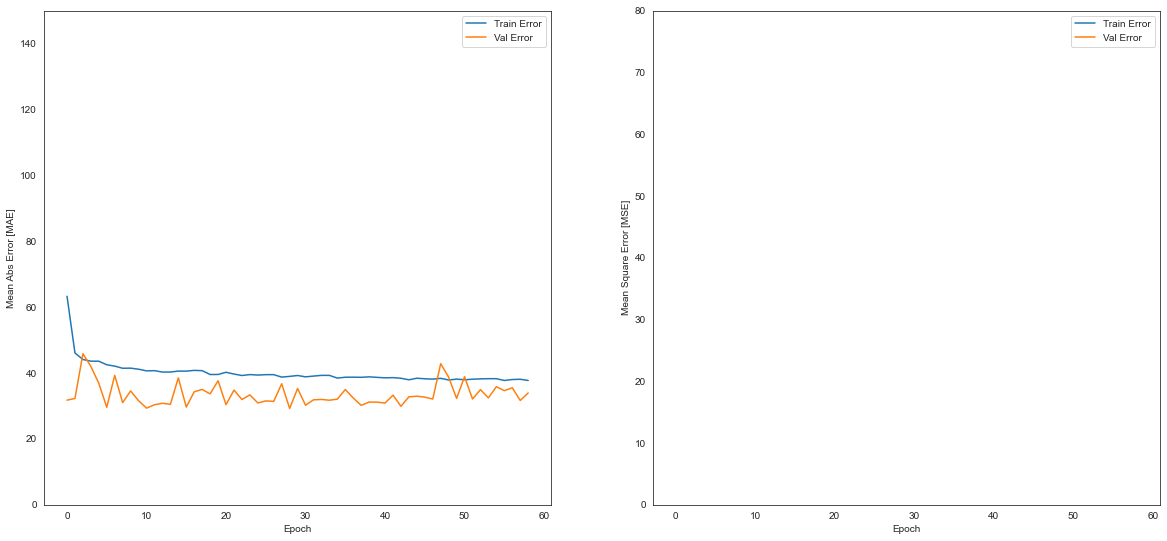

270/270 [==============================] - 0s 997us/step - loss: 39.4516 - mae: 39.4516 - mse: 7465.7500
dangjin_floating test set의 MAE: 39.452


In [171]:
model_dangjin, model_warehouse, model_floating, history_dangjin, history_warehouse, history_floating = train(final_dataset_dangjin, final_dataset_ulsan, 'dangjin')

In [172]:
x_train, x_test, y_train, y_test = train_test_split(final_dataset_dangjin[dangjin_bound:dangjin_end][['cos(time)',
                                                                     'GHI',
                                                                     'Temperature',
                                                                     'Humidity',
                                                                     'Wind_x',
                                                                     'Wind_y']], 
                                                                final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_floating'],
                                                                test_size=0.2, shuffle=False)

In [241]:
def Evaluate_NMAE(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 2700
    target_idx = pd.DataFrame(sum_answer[sum_answer>=2700*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()
    return nmae

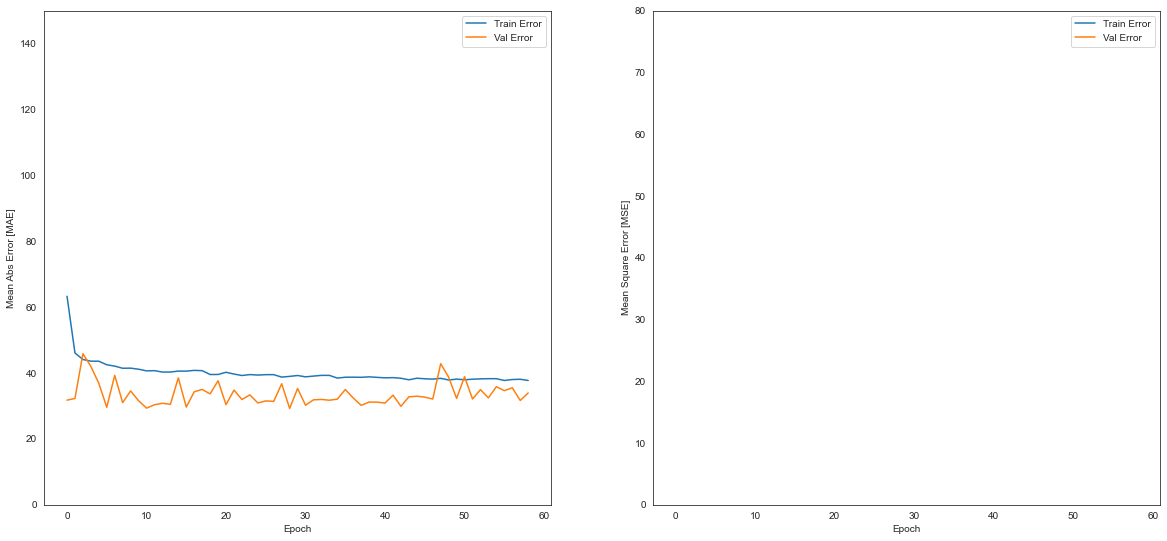

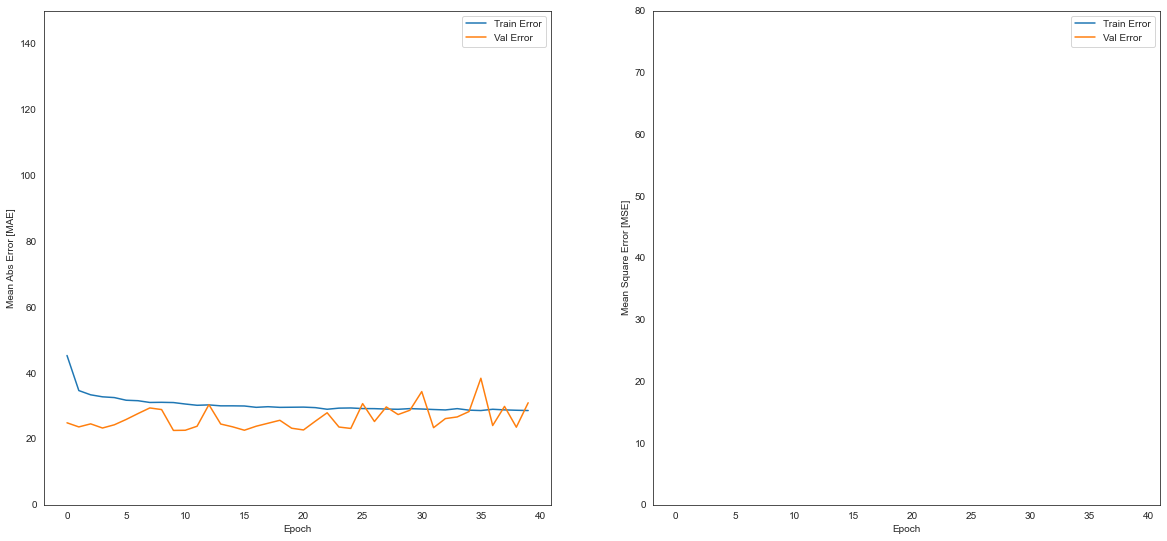

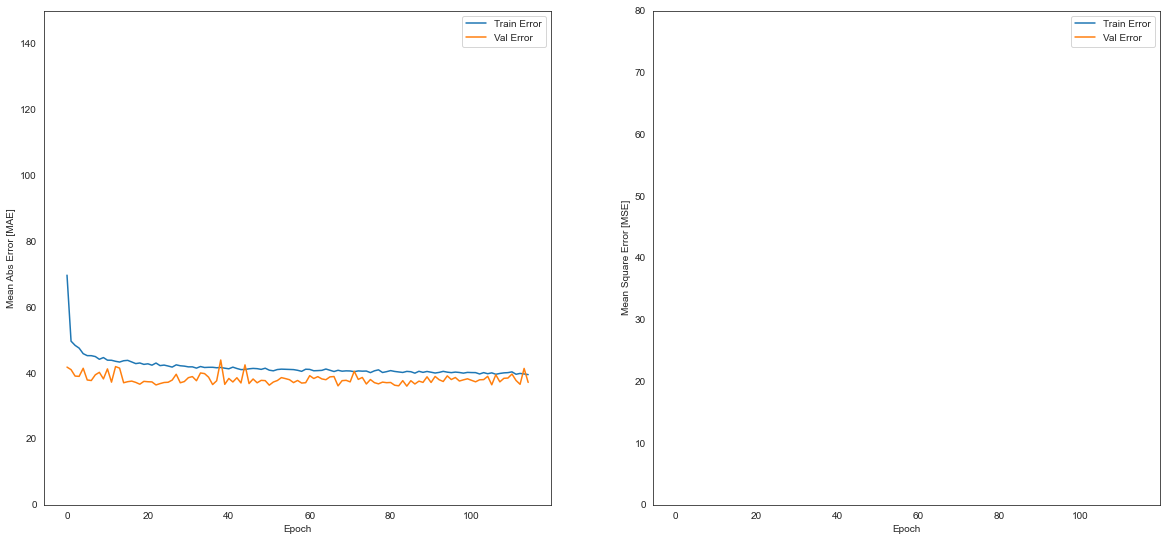

55/55 [==============================] - 0s 1ms/step - loss: 32.3753 - mae: 32.3753 - mse: 4633.4863
울산 제외 3개 장소 최종 submission 의 MAE: 32.375
[0.00035736 0.00035736 0.00035736 ... 0.00035736 0.00035736 0.00035736] [0. 0. 0. ... 0. 0. 0.]
NMAE for MLP : 3.2664313298493988


In [256]:
#=====================15~19 4개년 데이터로 20년 전체 예측============================#
plot_history(history_floating)
plot_history(history_warehouse)
plot_history(history_dangjin)
loss1, mae1, mse1 = model_floating.evaluate(x_test, y_test, verbose=1)
print("%s 의 MAE: %.3f"%('울산 제외 3개 장소 최종 submission',mae1))

answer_floating = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_floating']
answer_warehouse = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin_warehouse']
answer_dangjin = final_dataset_dangjin[dangjin_bound:dangjin_end]['dangjin']
answer_ulsan = final_dataset_ulsan[ulsan_bound:ulsan_end]['ulsan']

test_period = final_dataset_dangjin[dangjin_bound:dangjin_end][['cos(time)',
                                                                 'GHI',
                                                                 'Temperature',
                                                                 'Humidity',
                                                                 'Wind_x',
                                                                 'Wind_y']]

submission_floating = pd.DataFrame(np.squeeze(model_floating.predict(test_period)))
submission_warehouse = pd.DataFrame(np.squeeze(model_warehouse.predict(test_period)))
submission_dangjin = pd.DataFrame(np.squeeze(model_dangjin.predict(test_period)))
submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

answer_df = pd.concat([answer_dangjin, 
                       answer_warehouse, 
                       answer_floating,
                       answer_ulsan], axis=1).reset_index().drop('index', axis=1)
submission_df = pd.concat([submission_dangjin, 
                           submission_warehouse, 
                           submission_floating,
                           submission_ulsan], axis=1)
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

In [274]:
start = dangjin_end+31*24
end = dangjin_end+31*24+674
answer_floating = final_dataset_dangjin[start:end]['dangjin_floating']
answer_warehouse = final_dataset_dangjin[start:end]['dangjin_warehouse']
answer_dangjin = final_dataset_dangjin[start:end]['dangjin']
answer_ulsan = final_dataset_ulsan[start:end]['ulsan']

test_period = final_dataset_dangjin[start:end][['cos(time)',
                                                                 'GHI',
                                                                 'Temperature',
                                                                 'Humidity',
                                                                 'Wind_x',
                                                                 'Wind_y']]

submission_floating = pd.DataFrame(np.squeeze(model_floating.predict(test_period)))
submission_warehouse = pd.DataFrame(np.squeeze(model_warehouse.predict(test_period)))
submission_dangjin = pd.DataFrame(np.squeeze(model_dangjin.predict(test_period)))
submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

answer_df = pd.concat([answer_dangjin, 
                       answer_warehouse, 
                       answer_floating,
                       answer_ulsan], axis=1).reset_index().drop('index', axis=1)
submission_df = pd.concat([submission_dangjin, 
                           submission_warehouse, 
                           submission_floating,
                           submission_ulsan], axis=1)
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_df), pd.DataFrame(submission_df)))

[3.57358338e-04 3.57358338e-04 3.57358338e-04 3.57358338e-04
 3.57358338e-04 3.57358338e-04 9.62536186e-02 1.17664528e+01
 8.94199219e+01 2.17018005e+02 6.63222534e+02 9.69251770e+02
 9.40679077e+02 4.97827332e+02 8.46508118e+02 6.84456604e+02
 2.51409271e+02 1.39155136e+02 3.69622782e-02 3.57358338e-04
 3.57358338e-04 3.57358338e-04 3.57358338e-04 3.57358338e-04
 3.57358338e-04 3.57358338e-04 3.57358338e-04 3.57358338e-04
 3.57358338e-04 3.57358338e-04 3.57358338e-04 1.94994044e+00
 1.43276382e+02 6.30219238e+02 1.36666235e+03 1.94755359e+03
 2.14126440e+03 2.12733228e+03 1.97522107e+03 1.62510327e+03
 6.94968201e+02 1.85105682e+02 3.57358338e-04 3.57358338e-04
 3.57358338e-04 3.57358338e-04 3.57358338e-04 3.57358338e-04
 3.57358338e-04 3.57358338e-04 3.57358338e-04 3.57358338e-04
 3.57358338e-04 3.57358338e-04 3.57358338e-04 4.35455847e+00
 1.74022202e+02 9.08942261e+02 1.55781689e+03 1.87170142e+03
 2.08958179e+03 2.03797974e+03 1.61748450e+03 1.19850781e+03
 8.64852295e+02 1.646042

In [286]:
s = np.where(raw_weather_dangjin['Time'] == '2021-02-01 0:00')[0][0]

In [287]:
e = np.where(raw_weather_dangjin['Time'] == '2021-03-01 0:00')[0][0]

In [293]:
time_axis = raw_weather_dangjin['Time'][s:e].reset_index().drop('index', axis=1)

new_submission = pd.concat([time_axis, submission_df],axis=1)

In [301]:
submission = new_submission[:672]

In [310]:
submission.columns = ['time', 'dangjin_floating', 'dangjin_warehouse','dangjin',"ulsan"]

In [329]:
sample_submission = pd.read_csv('solar_power_mycode/sample_submission.csv')

In [338]:
final_submission = pd.concat([sample_submission['time'],final_submission.drop('time', axis=1)], axis=1)

In [340]:
final_submission.to_csv('210528_YJ_submission.csv', header=True, index=False)

In [339]:
final_submission

,time,dangjin_floating,dangjin_warehouse,dangjin,ulsan
0,2021-02-01 01:00:00,0.00032,0.000004,0.000229,-0.000196
1,2021-02-01 02:00:00,0.00032,0.000004,0.000229,-0.000196
2,2021-02-01 03:00:00,0.00032,0.000004,0.000229,-0.000196
3,2021-02-01 04:00:00,0.00032,0.000004,0.000229,-0.000196
4,2021-02-01 05:00:00,0.00032,0.000004,0.000229,-0.000196
...,...,...,...,...,...
1387,2021-07-08 20:00:00,0.00000,0.000000,0.000000,0.000000
1388,2021-07-08 21:00:00,0.00000,0.000000,0.000000,0.000000
1389,2021-07-08 22:00:00,0.00000,0.000000,0.000000,0.000000
1390,2021-07-08 23:00:00,0.00000,0.000000,0.000000,0.000000


In [321]:
submission.to_csv('submission_df_210528.csv')

In [252]:
x_train_ulsan, x_test_ulsan, y_train_ulsan, y_test_ulsan = train_test_split(
                    final_dataset_ulsan[ulsan_bound:ulsan_end][['cos(time)',
                                                                     'GHI',
                                                                     'Temperature',
                                                                     'Humidity',
                                                                     'Wind_x',
                                                                     'Wind_y']], 
                                                                final_dataset_ulsan[ulsan_bound:ulsan_end]['ulsan'],
                                                                test_size=0.2, shuffle=False)

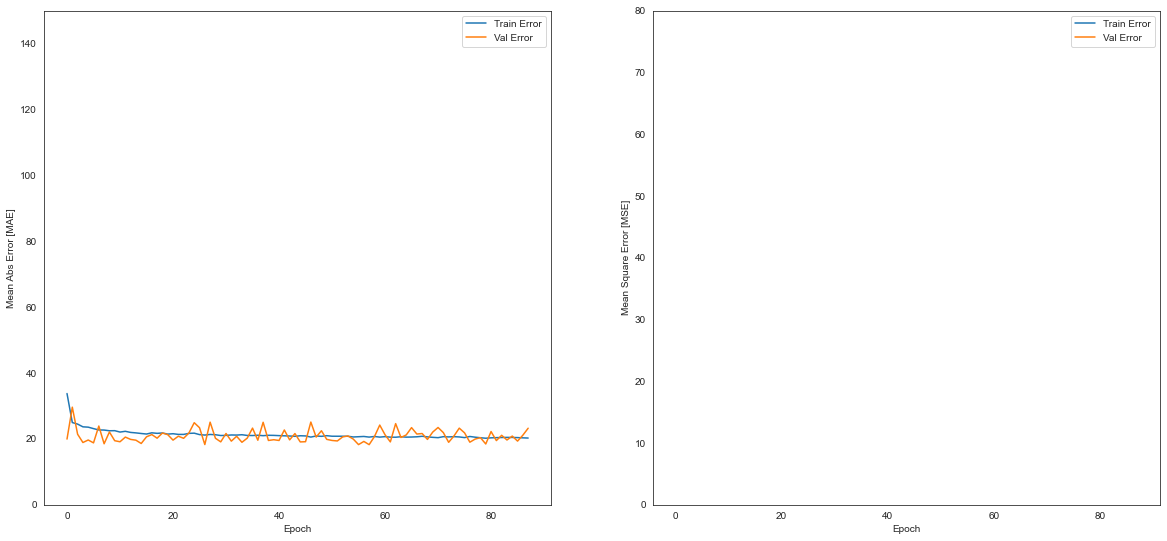

55/55 [==============================] - 0s 1ms/step - loss: 17.8451 - mae: 17.8451 - mse: 1200.2841
울산 제외 3개 장소 최종 submission 의 MAE: 17.845
[-1.95808214e-04 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04
 -1.95808214e-04 -1.95808214e-04  8.19070041e-01  8.33069611e+00
  9.44661903e+00  1.67734737e+01  4.53567924e+01  6.90170135e+01
  1.44938385e+02  1.89511520e+02  1.53593506e+02  1.40248962e+02
  1.26841743e+02  2.41178455e+01  1.98754203e-02 -1.95808214e-04
 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04
 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04
 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04  1.29666281e+00
  6.93194885e+01  1.62394287e+02  2.74862946e+02  3.58851532e+02
  3.84779572e+02  3.85746918e+02  3.55803314e+02  2.62839325e+02
  1.55520905e+02  1.52626381e+01 -1.95808214e-04 -1.95808214e-04
 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04
 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04 -1.95808214e-04
 -1.95808214e-

In [272]:
plot_history(history_ulsan)
loss1, mae1, mse1 = model_ulsan.evaluate(x_test_ulsan, y_test_ulsan, verbose=1)
print("%s 의 MAE: %.3f"%('울산 제외 3개 장소 최종 submission',mae1))

answer_ulsan = final_dataset_ulsan[ulsan_end+31*24:ulsan_end+31*24+674]['ulsan']

test_period = final_dataset_ulsan[ulsan_end+31*24:ulsan_end+31*24+674][['cos(time)',
                                                                 'GHI',
                                                                 'Temperature',
                                                                 'Humidity',
                                                                 'Wind_x',
                                                                 'Wind_y']]

submission_ulsan = pd.DataFrame(np.squeeze(model_ulsan.predict(test_period)))

print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_ulsan), pd.DataFrame(submission_ulsan)))

## 3. 평가 및 시각화

In [39]:
#=========SVM 회귀==========#
from sklearn.svm import SVR

#GHI_svm_reg = SVR(kernel = 'rbf',degree=3, C=1000, epsilon = 0.01, verbose = True)
#GHI_svm_reg.fit(x_train_dangjin, y_train_dangjin)

In [132]:
#=========XGBoost 회귀==========#
import xgboost
from xgboost import XGBRegressor
GHI_xgb_reg = XGBRegressor()
GHI_xgb_reg.fit(x_train_dangjin, y_train_dangjin.astype(float))

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=16, num_parallel_tree=1, random_state=0,
             reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
             tree_method='exact', validate_parameters=1, verbosity=None)

In [133]:
import lightgbm
from lightgbm import LGBMRegressor
GHI_lgbm_reg = LGBMRegressor(boosting_type='gbdt',
                            num_leaves = 256,
                            max_depth = 9,
                            learning_rate = 0.05,
                            n_estimators=100)
GHI_lgbm_reg.fit(x_train_dangjin, y_train_dangjin.astype(float))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\lightgbm\basic.py:154: UserWarning: Converting column-vector to 1d array
  _log_warning('Converting column-vector to 1d array')


LGBMRegressor(learning_rate=0.05, max_depth=9, num_leaves=256)

In [232]:
def Evaluate_NMAE_dangjin(answer_df, submission_df):
    sum_submission = np.array(submission_df.iloc[:,0:].sum(axis=1))
    sum_answer = np.array(answer_df.values.sum(axis=1))
    absolute_error = np.abs(sum_answer-sum_submission)
    absolute_error /= 1000
    target_idx = pd.DataFrame(sum_answer[sum_answer>=1000*0.1]).index
    nmae = 100 * absolute_error[target_idx].mean()

    return nmae

In [210]:
answer_dangjin = raw_power_dangjin[train_bound:]
answer_warehouse = raw_power_warehouse[train_bound:]
answer_ulsan = raw_power_ulsan[train_bound:]
dangjin_2021_01 = proc_data_dangjin[train_bound:]
warehouse_2021_01 = proc_data_dangjin[train_bound:]
ulsan_2021_01 = proc_data_ulsan[train_bound:]
MLP_submission_df = np.squeeze(model_dangjin.predict(dangjin_2021_01))
ware_submission_df = np.squeeze(model_warehouse.predict(warehouse_2021_01))
#MLP_submission_ulsan = np.squeeze(model_ulsan.predict((ulsan_2021_01)))
LGB_submission_df = np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))
#SVM_submission_df = np.squeeze(GHI_svm_reg.predict(GHI_2021_01))
XGB_submission_df = np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))

C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


In [211]:
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(MLP_submission_df)))
print("NMAE, MLP, warehouse :",Evaluate_NMAE_ware(pd.DataFrame(answer_warehouse), pd.DataFrame(ware_submission_df)))

#print("NMAE for ULS :",Evaluate_NMAE(answer_ulsan, MLP_submission_ulsan))
print("NMAE for LGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
#print("NMAE for SVM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(SVM_submission_df)))
print("NMAE for XGB :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))

NMAE for MLP : 4.318632084217226
NMAE, MLP, warehouse : 8.054132769107982
NMAE for LGB : 5.8487756257097585
NMAE for XGB : 6.480300503433263


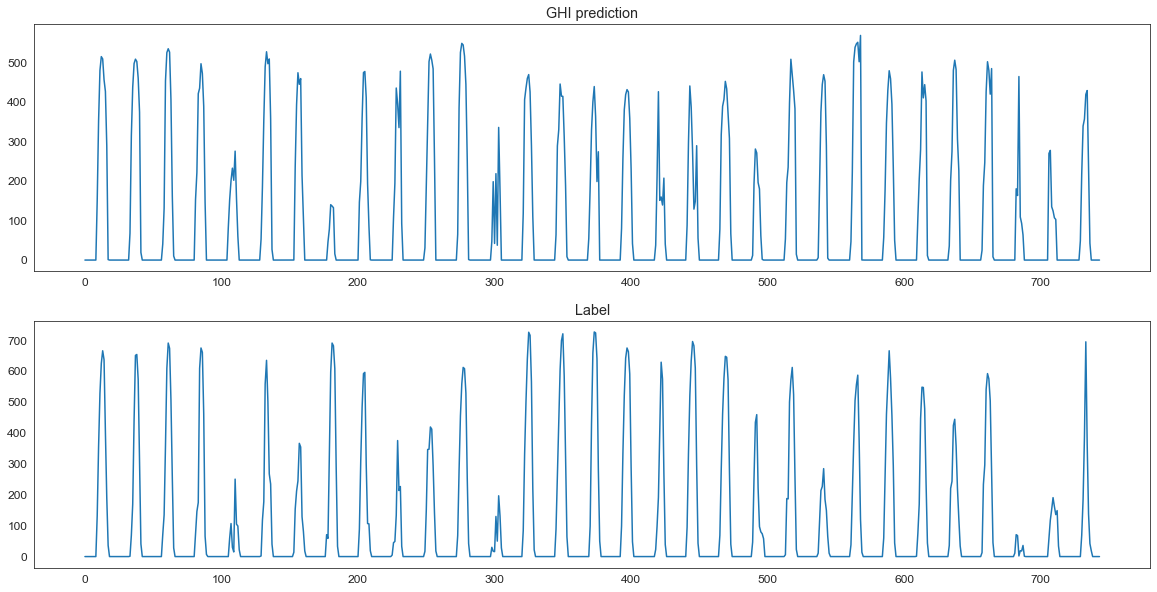

In [149]:
length = 25632-24888
fig = plt.figure(figsize=(20,10))
plt.rc('font', size = 12)
plt.subplot(211)
plt.title('GHI prediction')
plt.plot(range(0,len(dangjin_temp['cos(time)'][-length:])), 
         np.squeeze(model_dangjin.predict(dangjin_2021_01))[-length:])

plt.subplot(212)
plt.title('Label')
plt.plot(range(0,len(dangjin_temp['cos(time)'][-length:])), 
         raw_power_dangjin[-length:])

In [215]:
year = 24*365

In [223]:
np.where(answer_floating>)

(array([], dtype=int64),)

In [226]:
reset

,index,dangjin_floating
0,54768,0.0
1,54769,0.0
2,54770,0.0
3,54771,0.0
4,54772,0.0
...,...,...
715,55483,0.0
716,55484,0.0
717,55485,0.0
718,55486,0.0


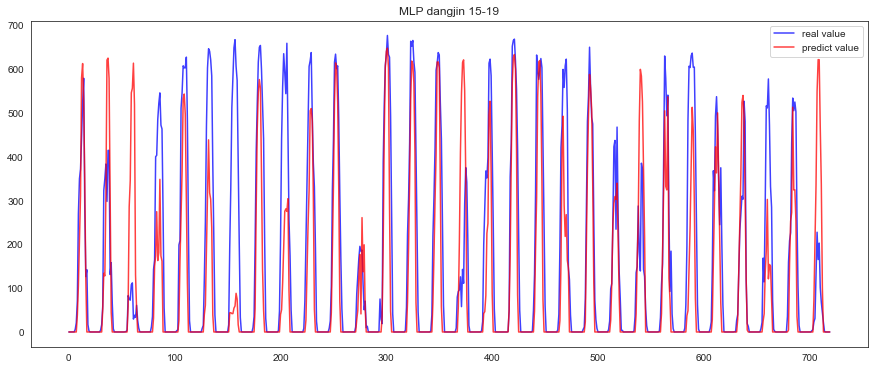

In [230]:
place = ['dangjin','dangjin_warehouse','dangjin_floating']
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin[place[2]][-24*30:].reset_index()
chart.plot(reset[place[2]], marker='', color='blue', alpha = 0.75, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(test_period))[-24*30:], marker='', color='red', alpha = 0.75, label='predict value')
chart.set_title('MLP dangjin 15-19')
plt.legend(loc = 'best') 

NameError: name 'answer_dangjin' is not defined

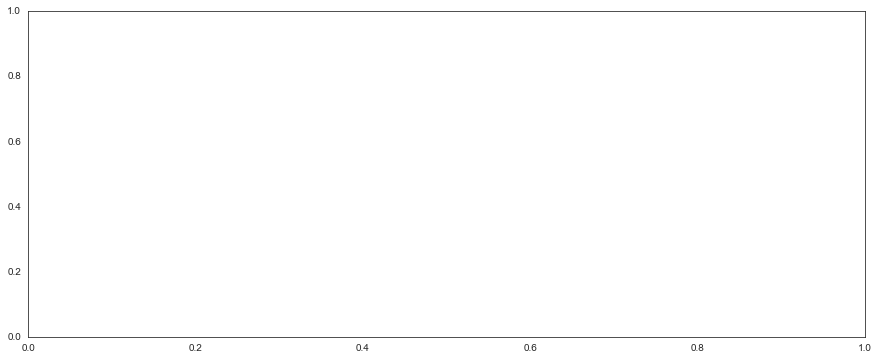

In [188]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = final_dataset_dangjin['dangjin'][-24*365:].reset_index()
print("NMAE for MLP :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(submission_dangjin)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(model_dangjin.predict(test_period))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('MLP dangjin 15-19')
plt.legend(loc = 'best');

NMAE for LGBM : 5.8487756257097585


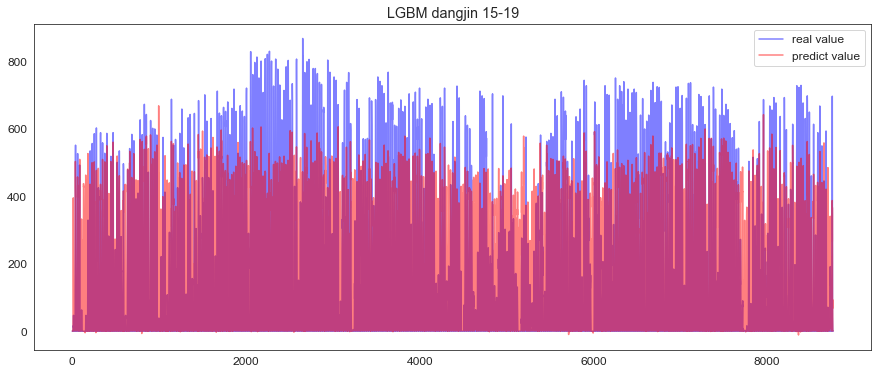

In [232]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for LGBM :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(LGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_lgbm_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.50,
                                                                   label='predict value')
chart.set_title('LGBM dangjin 15-19')
plt.legend(loc = 'best');

NMAE for XGBoost : 6.480300503433263


C:\Users\aai-pc-8\anaconda3\envs\DeepLearning\lib\site-packages\xgboost\data.py:112: UserWarning: Use subset (sliced data) of np.ndarray is not recommended because it will generate extra copies and increase memory consumption
  warnings.warn(


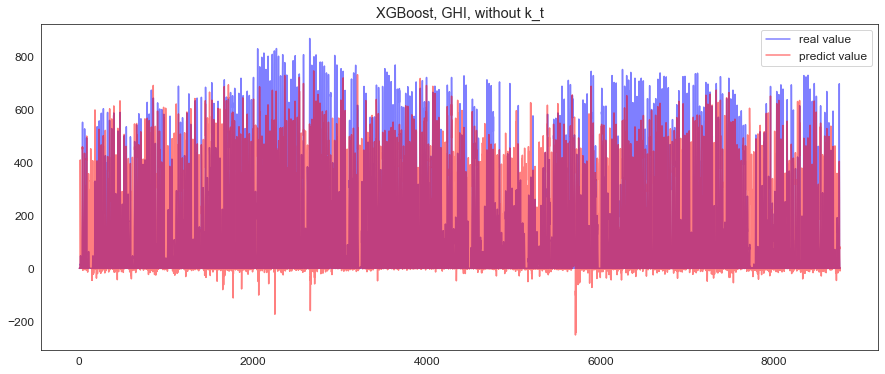

In [227]:
fig = plt.figure( figsize = (15, 6) )
chart = fig.add_subplot(1,1,1)
reset = raw_power_dangjin[-year:].reset_index()
print("NMAE for XGBoost :",Evaluate_NMAE(pd.DataFrame(answer_dangjin), pd.DataFrame(XGB_submission_df)))
chart.plot(reset['dangjin'], marker='', color='blue', alpha = 0.5, label='real value')
chart.plot(np.squeeze(GHI_xgb_reg.predict(dangjin_2021_01))[-year:], marker='', color='red', alpha = 0.5, label='predict value')
chart.set_title('XGBoost, GHI, without k_t')
plt.legend(loc = 'best')

In [ ]:
fig = plt.figure(figsize = (20, 10))
plt.subplot(211)
sns.lineplot(data=data_dangjin, x= data_dangjin.index, y = 'Power', linewidth = 0.2)

In [289]:
reset['Power']

0      0
1      0
2      0
3      0
4      0
      ..
739    0
740    0
741    0
742    0
743    0
Name: Power, Length: 744, dtype: int64